**Table of contents**<a id='toc0_'></a>

- [Import Libraries](#toc1_1_)
  - [Get Data](#toc1_2_)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


## <a id='toc1_1_'></a>[Import Libraries](#toc0_)


In [76]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

# get data from TradingView
from tvDatafeed import TvDatafeed, Interval
from enum import Enum

tv = TvDatafeed()

In [77]:
class TimeFrame(Enum):
    DAILY = "daily"
    YEARLY = "yearly"


class Method(Enum):
    PERCENTAGE = "pct"
    HLO = "hlo"  # (high - low) / close

## <a id='toc1_2_'></a>[Get Data](#toc0_)


In [3]:
interval = Interval.in_daily

data = tv.get_hist(symbol="USOIL", exchange="TVC", interval=interval, n_bars=10_000)
data

,symbol,open,high,low,close,volume
datetime,,,,,,
1984-11-02 05:00:00,TVC:USOIL,28.670,28.720,28.54,28.650,0.0
1984-11-05 05:00:00,TVC:USOIL,28.610,28.650,28.48,28.550,0.0
1984-11-06 05:00:00,TVC:USOIL,28.540,28.720,28.51,28.700,0.0
1984-11-07 05:00:00,TVC:USOIL,28.820,28.870,28.58,28.730,0.0
1984-11-08 05:00:00,TVC:USOIL,28.670,28.700,28.53,28.680,0.0
...,...,...,...,...,...,...
2024-04-18 05:00:00,TVC:USOIL,82.260,82.805,81.09,81.848,0.0
2024-04-19 05:00:00,TVC:USOIL,81.975,85.580,81.18,82.067,0.0
2024-04-22 05:00:00,TVC:USOIL,81.825,82.250,80.74,82.078,0.0


In [4]:
START_YEAR = 2013
END_YEAR = 2024

# filtered year
filtered_data = data[(data.index.year >= START_YEAR) & (data.index.year <= END_YEAR)]

## Close Price Distribution

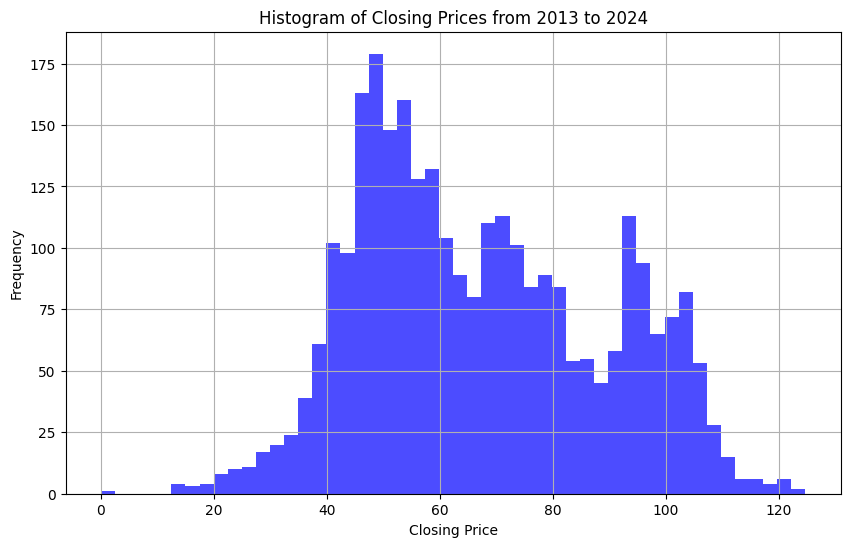

In [5]:
def plot_close_prices_histogram(
    data: pd.DataFrame,
    title=None,
    x_label="Closing Price",
    y_label="Frequency",
    grid=True,
):
    """Plot the close price histogram"""
    # Check if DataFrame index is of datetime type
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be of datetime type")

    plt.figure(figsize=(10, 6))
    plt.hist(data["close"], bins=50, color="blue", alpha=0.7)

    # customization
    if title:
        plt.title(title)
    else:
        plt.title(
            f"Histogram of Closing Prices from {data.index.year[0]} to {data.index.year[-1]}"
        )

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if grid:
        plt.grid(True)


plot_close_prices_histogram(data=filtered_data)

### Stdev

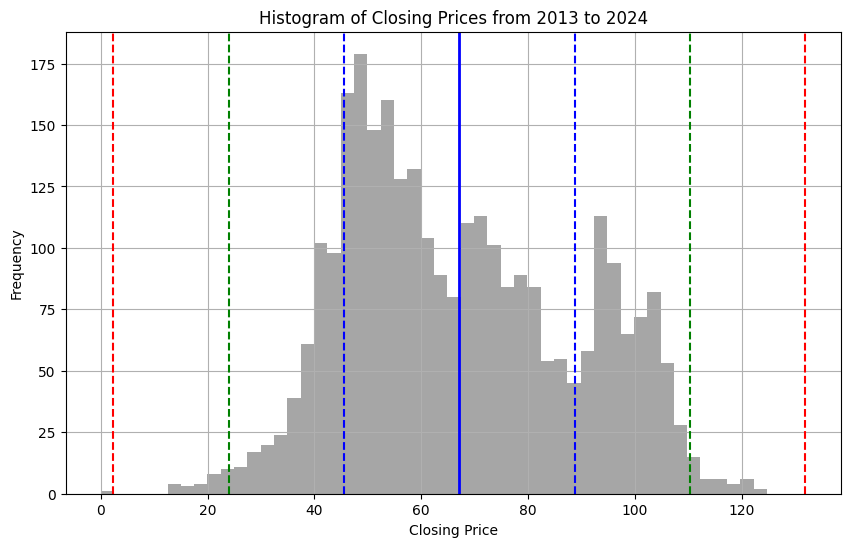

In [78]:
def plot_close_prices_histogram_with_stdev(
    data: pd.DataFrame,
    title=None,
    x_label="Closing Price",
    y_label="Frequency",
    grid=True,
):
    """Plot the close price histogram"""
    # Check if DataFrame index is of datetime type
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be of datetime type")

    mean = data["close"].mean()
    std = data["close"].std()
    stdev_pos_1, stdev_neg_1, stdev_pos_2, stdev_neg_2, stdev_pos_3, stdev_neg_3 = (
        _cal_stdev(mean=mean, std=std)
    )

    plt.figure(figsize=(10, 6))
    plt.hist(data["close"], bins=50, color="grey", alpha=0.7)

    # Add vertical lines for mean and SD ranges
    plt.axvline(mean, color="blue", linestyle="-", linewidth=2, label="Mean")
    plt.axvline(stdev_pos_1, color="blue", linestyle="--", label="Mean + 1SD")
    plt.axvline(stdev_neg_1, color="blue", linestyle="--", label="Mean - 1SD")
    plt.axvline(stdev_pos_2, color="green", linestyle="--", label="Mean + 2SD")
    plt.axvline(stdev_neg_2, color="green", linestyle="--", label="Mean - 2SD")
    plt.axvline(stdev_pos_3, color="red", linestyle="--", label="Mean + 3SD")
    plt.axvline(stdev_neg_3, color="red", linestyle="--", label="Mean - 3SD")

    # customization
    if title:
        plt.title(title)
    else:
        plt.title(
            f"Histogram of Closing Prices from {data.index.year[0]} to {data.index.year[-1]}"
        )

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if grid:
        plt.grid(True)


def _cal_stdev(
    mean: float, std: float
) -> tuple[float, float, float, float, float, float]:
    stdev_pos_1 = mean + std
    stdev_neg_1 = mean - std
    stdev_pos_2 = mean + 2 * std
    stdev_neg_2 = mean - 2 * std
    stdev_pos_3 = mean + 3 * std
    stdev_neg_3 = mean - 3 * std

    return stdev_pos_1, stdev_neg_1, stdev_pos_2, stdev_neg_2, stdev_pos_3, stdev_neg_3


plot_close_prices_histogram_with_stdev(data=filtered_data[filtered_data["close"] > 0])

### Peak Density

In [133]:
# หาจุด peak dist tri
# หาระยะ

## Stats Volatility


In [97]:
def cal_voltility(data: pd.DataFrame, timeframe=TimeFrame, method=Method) -> pd.Series:
    """
    Calculate the volatility of financial data.

    Parameters
    ----------
    data : pd.DataFrame
        A DataFrame containing financial data, including columns for 'open', 'high', 'low', and 'close'.
    timeframe : TimeFrame, optional
        The timeframe over which to calculate volatility, either TimeFrame.DAILY or TimeFrame.YEARLY.
        Defaults to TimeFrame.DAILY.
    method : Method, optional
        The method to use for calculating volatility, either Method.PERCENTAGE or Method.HLO.
        Defaults to Method.PERCENTAGE.

    Returns
    -------
    pd.Series
        A pandas Series containing the calculated volatility.

    Raises
    ------
    ValueError
        If an invalid method is provided.
    """
    def _cal_method(data: pd.Series):
        return (data.groupby(data.index.year).std()
            if timeframe == TimeFrame.DAILY
            else  data.groupby(data.index.year).std() * np.sqrt(252)
        )
        
    if method == Method.PERCENTAGE:
        volatility = data["close"].pct_change()
        return _cal_method(data=volatility)
    elif method == method.HLO:
        volatility = (data["high"] - data["low"]) / data["open"]
        return _cal_method(data=volatility)
    else:
        raise ValueError("Not found method!")


def cal_stats(data: pd.Series):
    """Calculate the min max and mean from the series data which normalized as percentage"""
    data_min = round(data.min(), 2)
    data_max = round(data.max(), 2)
    data_mean = round(data.mean(), 2)

    # Output
    print(f"min: {data_min}%\nmax: {data_max}%\nmean: {data_mean}%")

    return data_min, data_max, data_max

### Percentage Change


The standard deviation of daily returns for each year.


In [128]:
daily_volatility = (
    cal_voltility(filtered_data, timeframe=TimeFrame.DAILY, method=Method.PERCENTAGE)
    * 100
)

# filter blackswan
filtered_daily_volatility = daily_volatility[daily_volatility < daily_volatility.quantile(0.99)]

# output
cal_stats(data=filtered_daily_volatility)
print(filtered_daily_volatility)

# show remove outlier
remove_indices = daily_volatility.index.difference(filtered_daily_volatility.index)
print(f"\nRemove out of quantile 99%: \n{daily_volatility[remove_indices]}")

min: 1.16%
max: 3.03%
mean: 2.05%
datetime
2013    1.161640
2014    1.441502
2015    2.710757
2016    2.920519
2017    1.538632
2018    1.997306
2019    1.964464
2021    2.220354
2022    3.025110
2023    2.098317
2024    1.434856
Name: close, dtype: float64

Remove out of quantile 99%: 
datetime
2020    8989.85588
Name: close, dtype: float64


The annualized standard deviation of returns for each year


In [129]:
annualized_volatility = (
    cal_voltility(filtered_data, timeframe=TimeFrame.YEARLY, method=Method.PERCENTAGE) * 100
)

# filter blackswan
filtered_annualized_volatility = annualized_volatility[annualized_volatility < annualized_volatility.quantile(0.99)]
# output
cal_stats(data=filtered_annualized_volatility)
print(filtered_annualized_volatility)

# show remove outlier
remove_indices = annualized_volatility.index.difference(filtered_annualized_volatility.index)
print(f"\nRemove out of quantile 99%: \n{annualized_volatility[remove_indices]}")

min: 18.44%
max: 48.02%
mean: 32.49%
datetime
2013    18.440470
2014    22.883138
2015    43.031938
2016    46.361802
2017    24.425026
2018    31.706256
2019    31.184894
2021    35.247026
2022    48.022139
2023    33.309755
2024    22.777638
Name: close, dtype: float64

Remove out of quantile 99%: 
datetime
2020    142709.537878
Name: close, dtype: float64


### (High - Low) / Open


The standard deviation of daily returns for each year.


In [131]:
daily_volatility = (
    cal_voltility(filtered_data, timeframe=TimeFrame.DAILY, method=Method.HLO)
    * 100
)

# filter blackswan
filtered_daily_volatility = daily_volatility[daily_volatility < daily_volatility.quantile(0.99)]

# output
cal_stats(data=filtered_daily_volatility)
print(filtered_daily_volatility)

# show remove outlier
remove_indices = daily_volatility.index.difference(filtered_daily_volatility.index)
print(f"\nRemove out of quantile 99%: \n{annualized_volatility[remove_indices]}")

min: 0.65%
max: 2.07%
mean: 1.43%
datetime
2013    0.647634
2014    1.383171
2015    1.816340
2016    2.031555
2017    1.048406
2018    1.421185
2019    1.476174
2021    1.615932
2022    2.074662
2023    1.273501
2024    0.966900
dtype: float64

Remove out of quantile 99%: 
datetime
2020    142709.537878
Name: close, dtype: float64


The annualized standard deviation of returns for each year


In [132]:
annualized_volatility = (
    cal_voltility(filtered_data, timeframe=TimeFrame.YEARLY, method=Method.HLO) * 100
)

# filter blackswan
filtered_annualized_volatility = annualized_volatility[annualized_volatility < annualized_volatility.quantile(0.99)]

# output
cal_stats(data=filtered_annualized_volatility)
print(filtered_annualized_volatility)

# show remove outlier
remove_indices = annualized_volatility.index.difference(filtered_annualized_volatility.index)
print(f"\nRemove out of quantile 99%: {annualized_volatility[remove_indices]}")

min: 10.28%
max: 32.93%
mean: 22.74%
datetime
2013    10.280871
2014    21.957153
2015    28.833509
2016    32.249944
2017    16.642933
2018    22.560618
2019    23.433533
2021    25.652121
2022    32.934245
2023    20.216206
2024    15.349058
dtype: float64

Remove out of quantile 99%: datetime
2020    150.843986
dtype: float64


C:\Users\puwat\AppData\Local\Temp\ipykernel_17824\3202712862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'y_values'] = (filtered_data['high'] - filtered_data['low']) / filtered_data['open']


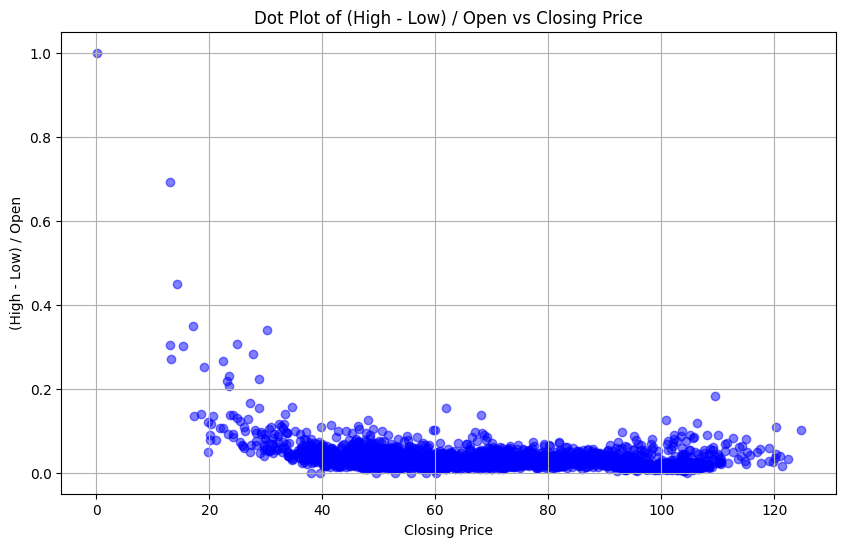

In [9]:
filtered_data.loc[:, "y_values"] = (
    filtered_data["high"] - filtered_data["low"]
) / filtered_data["open"]
# Create the dot plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data["close"], filtered_data["y_values"], alpha=0.5, color="blue")
plt.title("Dot Plot of (High - Low) / Open vs Closing Price")
plt.xlabel("Closing Price")
plt.ylabel("(High - Low) / Open")
plt.grid(True)
plt.show()

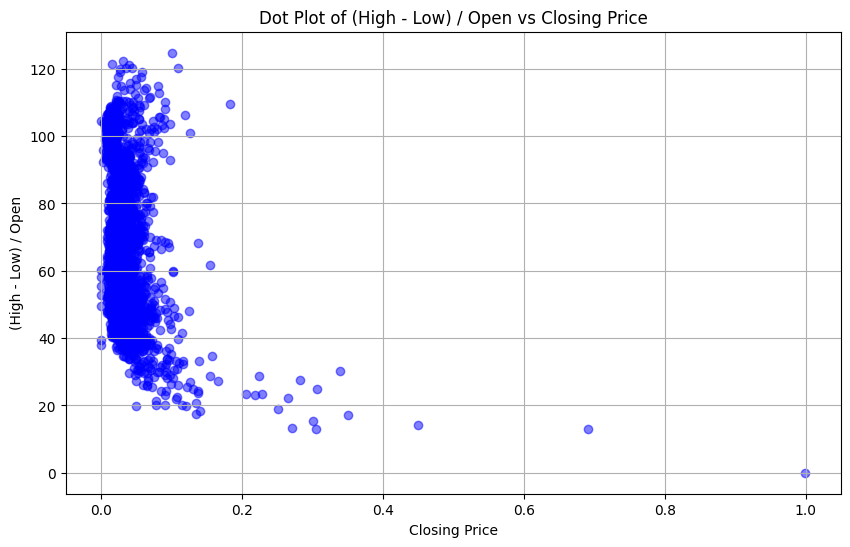

In [10]:
filtered_data.loc[:, "y_values"] = (
    filtered_data["high"] - filtered_data["low"]
) / filtered_data["open"]
# Create the dot plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data["y_values"], filtered_data["close"], alpha=0.5, color="blue")
plt.title("Dot Plot of (High - Low) / Open vs Closing Price")
plt.xlabel("Closing Price")
plt.ylabel("(High - Low) / Open")
plt.grid(True)
plt.show()